In [1]:
import os
import warnings

from pathlib import Path
from tqdm.auto import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

from fastai.vision.all import *
from torchvision.models import densenet201, resnet152, vgg19

from xrkit.base import CONFIG
from xrkit.utilities.seed import seed_everything

os.chdir('..')
sns.set_theme()
torch.set_float32_matmul_precision("high")

warnings.filterwarnings("ignore")

In [2]:
SEED = 34
seed_everything(SEED)

In [3]:
data_path = Path(CONFIG.data.chestxray2017_classification.raw_path)
test_path = Path(data_path, "test")

In [4]:
normal_cases_path = Path(test_path, "NORMAL")
pneumonia_cases_path = Path(test_path, "PNEUMONIA")

normal_cases = normal_cases_path.glob("*.jpeg")
pneumonia_cases = pneumonia_cases_path.glob("*.jpeg")

test_data = []

for image_path in normal_cases:
    test_data.append((image_path, 0))

for image_path in pneumonia_cases:
    test_data.append((image_path, 1))

test_data = pd.DataFrame(test_data, columns=["image", "label"], index=None)
test_data = test_data.sample(frac=1).reset_index(drop=True)

print(test_data.shape)
test_data.head()

(624, 2)


,image,label
0,data/raw/chest_xray/test/NORMAL/NORMAL2-IM-0348-0001.jpeg,0
1,data/raw/chest_xray/test/PNEUMONIA/person1669_virus_2884.jpeg,1
2,data/raw/chest_xray/test/PNEUMONIA/person80_bacteria_393.jpeg,1
3,data/raw/chest_xray/test/NORMAL/NORMAL2-IM-0217-0001.jpeg,0
4,data/raw/chest_xray/test/PNEUMONIA/person69_virus_129.jpeg,1


In [5]:
item_transforms = [
    Resize((224, 224)),
]

batch_transforms = [
    Normalize.from_stats(*imagenet_stats),
]


def get_x(row):
    return row["image"]


def get_y(row):
    return row["label"]


test_data_block = DataBlock(
    blocks=(ImageBlock, MultiCategoryBlock(encoded=True, vocab=["Pneumonia"])),
    splitter=RandomSplitter(valid_pct=0, seed=SEED),
    get_x=get_x,
    get_y=get_y,
    item_tfms=item_transforms,
    batch_tfms=batch_transforms,
)

test_dataloader = test_data_block.dataloaders(test_data, bs=CONFIG.base.batch_size)

In [6]:
models = [file for file in Path('models').glob("*.pth")]
print(models)

[Path('models/inceptionresnetv2.pth'), Path('models/resnet152.pth'), Path('models/mobilenetv2tl.pth'), Path('models/inceptionresnetv2tl.pth'), Path('models/nasnetalargetl.pth'), Path('models/vgg19tl.pth'), Path('models/xception.pth'), Path('models/inceptionv3.pth'), Path('models/mobilenetv2.pth'), Path('models/inceptionv3tl.pth'), Path('models/resnet152tl.pth'), Path('models/densenet201.pth'), Path('models/nasnetalarge.pth'), Path('models/densenet201tl.pth'), Path('models/xceptiontl.pth'), Path('models/vgg19.pth')]


In [7]:
model_networks = {
    'densenet201': densenet201,
    'resnet152': resnet152,
    'nasnetalarge': 'nasnetalarge',
    'vgg19': vgg19,
    'xception': 'legacy_xception',
    'inceptionv3': 'inception_v3',
    'inceptionresnetv2': 'inception_resnet_v2',
    'mobilenetv2': 'mobilenetv2_100',
}

model_networks.update({model + 'tl': network for model, network in model_networks.items()})

In [8]:
models_predictions = {}
models_targets = {}
for model in tqdm(models):
    network = model_networks.get(model.stem)

    if network is None:
        continue

    learner = vision_learner(test_dataloader, network, metrics=[accuracy_multi, F1ScoreMulti(), RocAucMulti()])
    learner.model = torch.nn.DataParallel(learner.model)

    learner.load(model.stem)
    learner.to("cuda")

    learner.freeze()

    predictions, targets = learner.get_preds(ds_idx=0)

    models_predictions[model.stem] = predictions
    models_targets[model.stem] = targets

  0%|          | 0/16 [00:00<?, ?it/s]

In [9]:
from sklearn.metrics import f1_score as skf1_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from torchmetrics.classification import ROC
from torchmetrics.functional import accuracy, auroc, f1_score

In [10]:
ordered_models = list(models_predictions.keys())
ordered_models.sort()

In [11]:
results = []
for index, model in enumerate(ordered_models):
    kwargs = {"preds": models_predictions[model][:, 0], "target": models_targets[model].int(), "task": "binary"}
    
    current_result = {
        'model': model,
        'global_f1': np.round(f1_score(**kwargs, average="macro").item(), 3),
        'normal_f1': np.round(skf1_score(kwargs["target"], kwargs["preds"] > 0.5, average=None).tolist(), 3)[0],
        'pneumonia_f1': np.round(skf1_score(kwargs["target"], kwargs["preds"] > 0.5, average=None).tolist(), 3)[1],
        'global_accuracy': np.round(accuracy(**kwargs, average="macro").item(), 3),
        'global_auroc': np.round(auroc(**kwargs, average="macro").item(), 3)
    }

    results.append(current_result)

pd.DataFrame(results).set_index('model').to_latex()

,global_f1,normal_f1,pneumonia_f1,global_accuracy,global_auroc
model,,,,,
densenet201,0.909,0.815,0.909,0.878,0.932
densenet201tl,0.900,0.795,0.900,0.865,0.922
inceptionresnetv2,0.857,0.739,0.857,0.816,0.862
inceptionresnetv2tl,0.910,0.818,0.910,0.880,0.951
inceptionv3,0.826,0.721,0.826,0.785,0.841
inceptionv3tl,0.891,0.762,0.891,0.851,0.933
mobilenetv2,0.889,0.800,0.889,0.857,0.913
mobilenetv2tl,0.892,0.760,0.892,0.851,0.940
nasnetalarge,0.867,0.717,0.867,0.819,0.886


In [15]:
print(pd.DataFrame(results).set_index('model').to_latex())

\begin{tabular}{lrrrrr}
\toprule
 & global_f1 & normal_f1 & pneumonia_f1 & global_accuracy & global_auroc \\
model &  &  &  &  &  \\
\midrule
densenet201 & 0.909000 & 0.815000 & 0.909000 & 0.878000 & 0.932000 \\
densenet201tl & 0.900000 & 0.795000 & 0.900000 & 0.865000 & 0.922000 \\
inceptionresnetv2 & 0.857000 & 0.739000 & 0.857000 & 0.816000 & 0.862000 \\
inceptionresnetv2tl & 0.910000 & 0.818000 & 0.910000 & 0.880000 & 0.951000 \\
inceptionv3 & 0.826000 & 0.721000 & 0.826000 & 0.785000 & 0.841000 \\
inceptionv3tl & 0.891000 & 0.762000 & 0.891000 & 0.851000 & 0.933000 \\
mobilenetv2 & 0.889000 & 0.800000 & 0.889000 & 0.857000 & 0.913000 \\
mobilenetv2tl & 0.892000 & 0.760000 & 0.892000 & 0.851000 & 0.940000 \\
nasnetalarge & 0.867000 & 0.717000 & 0.867000 & 0.819000 & 0.886000 \\
nasnetalargetl & 0.876000 & 0.703000 & 0.876000 & 0.825000 & 0.926000 \\
resnet152 & 0.882000 & 0.717000 & 0.882000 & 0.833000 & 0.897000 \\
resnet152tl & 0.893000 & 0.753000 & 0.893000 & 0.851000 & 0.939000

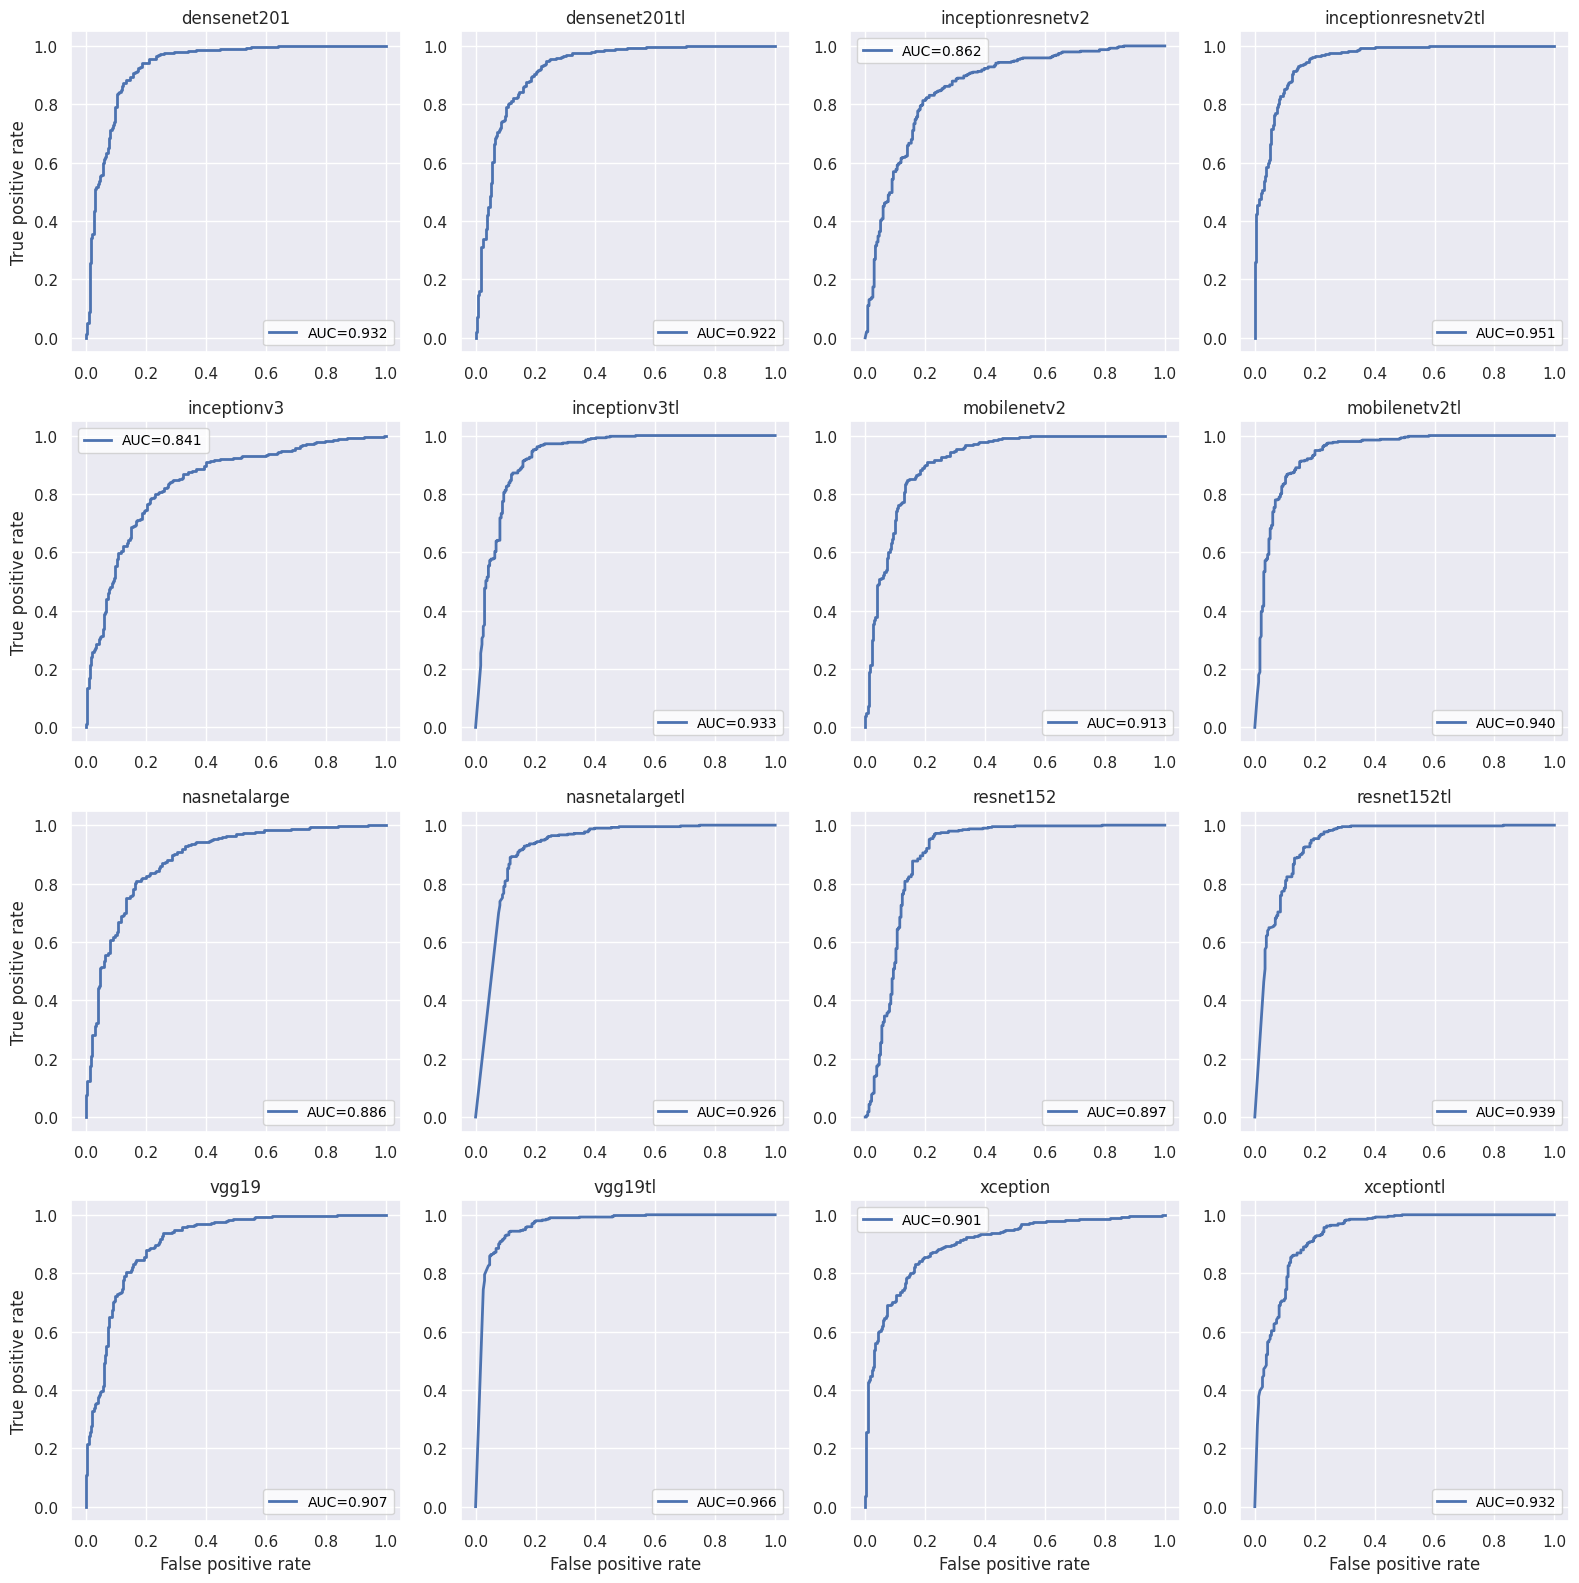

In [12]:
_, roc_axes = plt.subplots(4, 4, figsize=(16, 16))

for index, model in enumerate(ordered_models):
    kwargs = {"preds": models_predictions[model][:, 0], "target": models_targets[model].int(), "task": "binary"}

    roc = ROC(task="binary")
    roc(kwargs["preds"], kwargs["target"])

    roc_row, roc_column = index // 4, index % 4
    roc.plot(score=True, ax=roc_axes[roc_row][roc_column])
    handles, current_labels = roc_axes[roc_row][roc_column].get_legend_handles_labels()

    roc_axes[roc_row][roc_column].set_title(model)

    if roc_column != 0:
        roc_axes[roc_row][roc_column].set_ylabel('')

    if roc_row != 3:
        roc_axes[roc_row][roc_column].set_xlabel('')

plt.tight_layout()
plt.show()

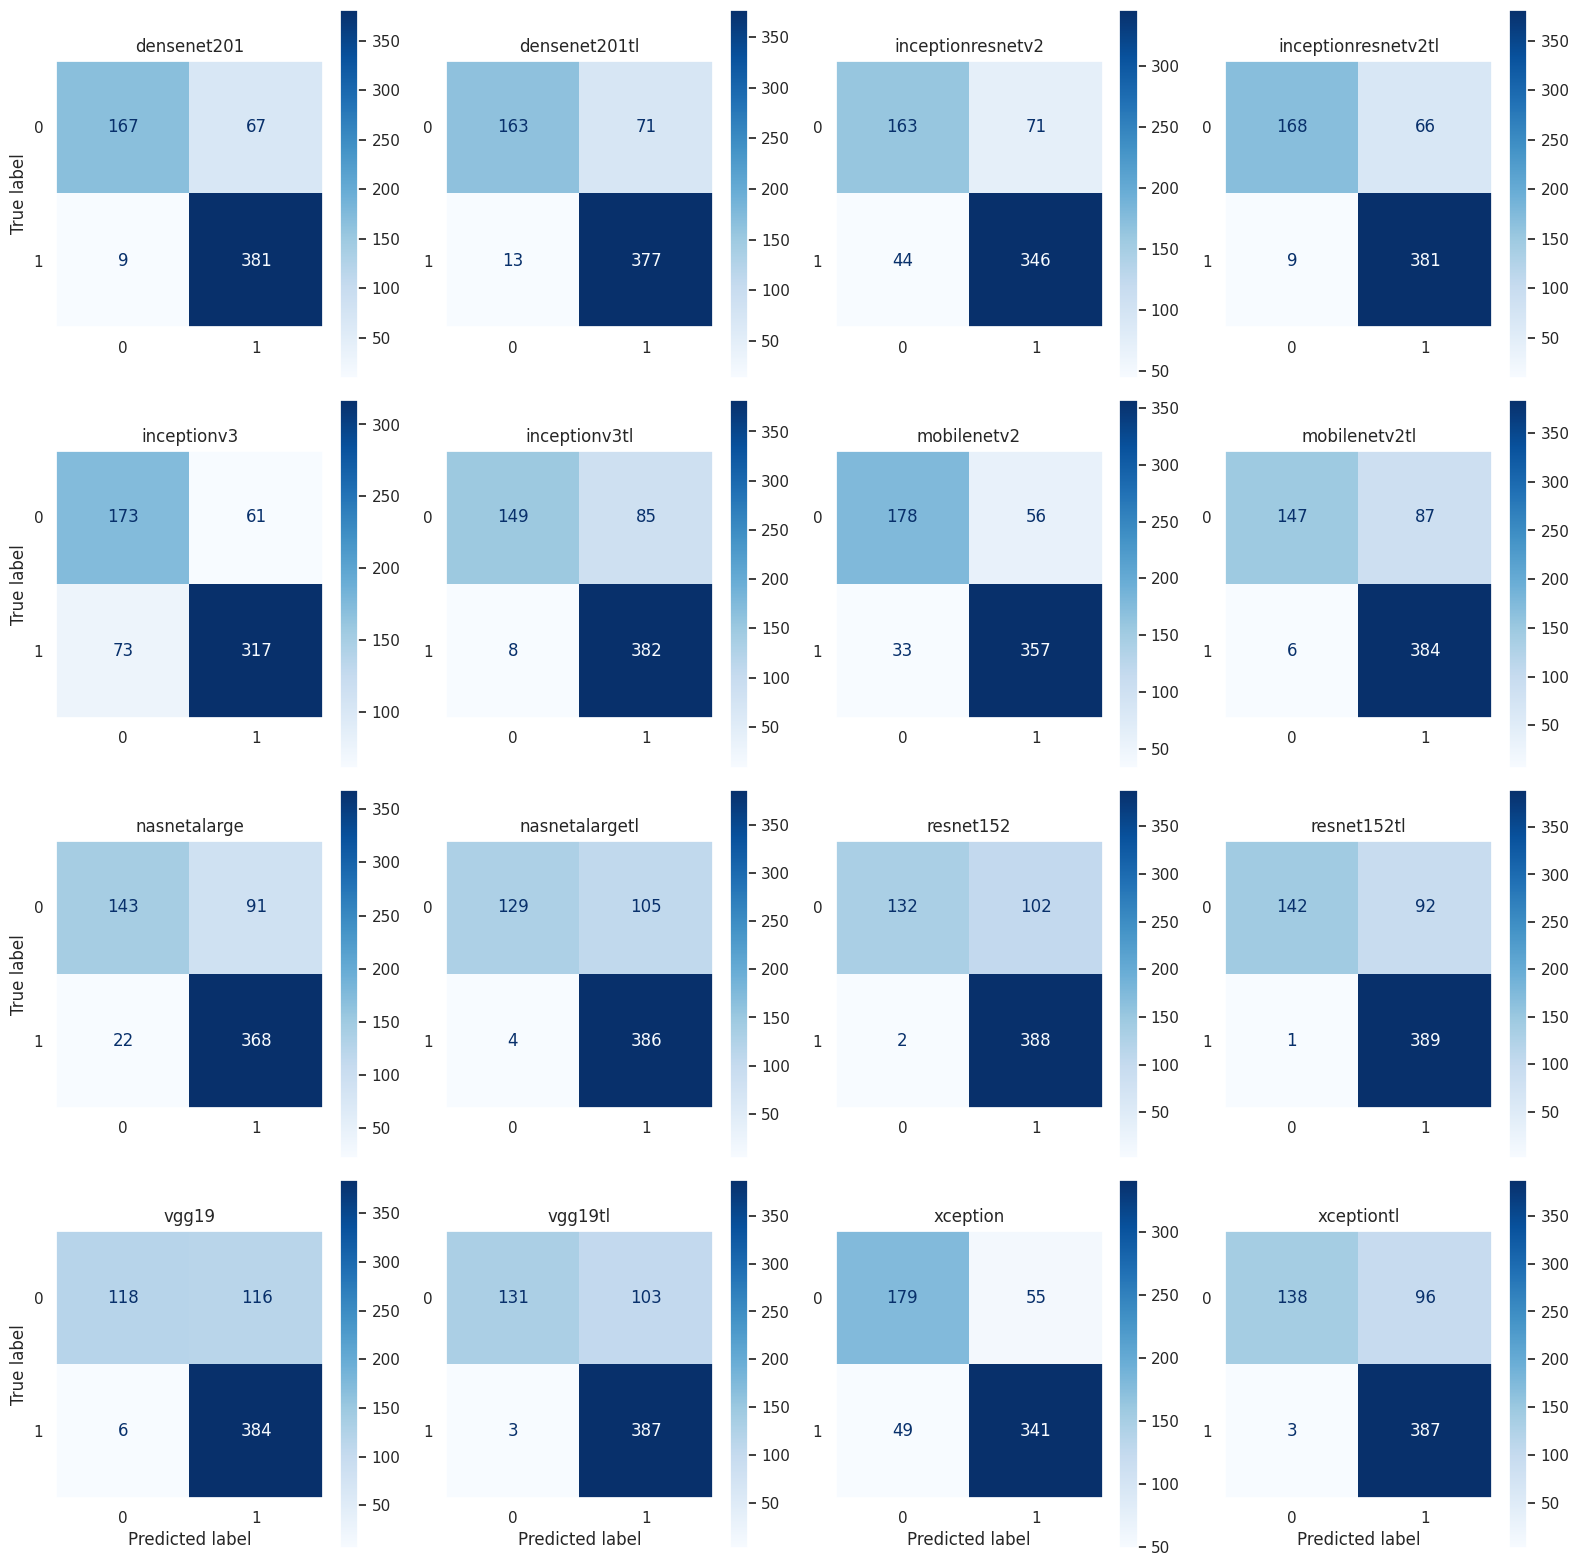

In [13]:
_, cm_axes = plt.subplots(4, 4, figsize=(16, 16))

for index, model in enumerate(ordered_models):
    kwargs = {"preds": models_predictions[model][:, 0], "target": models_targets[model].int(), "task": "binary"}

    cm_row, cm_column = index // 4, index % 4

    disp = ConfusionMatrixDisplay(confusion_matrix(kwargs["target"], kwargs["preds"] > 0.5))
    disp.plot(ax=cm_axes[cm_row][cm_column], cmap="Blues")

    handles, current_labels = cm_axes[cm_row][cm_column].get_legend_handles_labels()

    cm_axes[cm_row][cm_column].set_title(model)
    cm_axes[cm_row][cm_column].grid(False)

    if cm_column != 0:
        cm_axes[cm_row][cm_column].set_ylabel('')

    if cm_row != 3:
        cm_axes[cm_row][cm_column].set_xlabel('')

plt.tight_layout()
plt.show()